# Analysis & Plot the Asphalt Binder Frequency Sweep Test

This notebook includes the codes for analysis, plotting and statistical analysis on the results of Frequency Sweep test on different recovered binders used in the PTF lanes (no long-term aging and recovered from loose mix during construction). The analysis mainly include shifting, construction of master curve, and extracting some parameters.  

Author: Farhad Abdollahi (farhad.abdollahi.ctr@dot.gov) 

Date: 05/20/2025

___

In [16]:
# Importing the required libraries. 
import os
import pickle
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scripts.Statistical_Analysis import Tukey_Grouping
from scripts.Binder_FrequencySweep_Analysis import FreeShift_GordonShaw1994, Fit_MC_ChristensenAndersonMarasteanu, Fit_MC_ChristensenAnderson

In [17]:
# User input variables. 
MainDataFileName = './data/Data.xlsx'
OutputDir        = '../_Figures'

_______

### Read the data and perform the free shifting method. 

In [18]:
# Read the FS results as a big table. 
Res = pd.read_excel(MainDataFileName, sheet_name='Binder Frequency Sweep', usecols='A:IZ', skiprows=2)
# Divide the results into tables for different lanes. 
FS = {}
for i in range(10):
    df = Res.iloc[:, 26*i:26*(i+1)].copy()      # Get a copy of the data. 
    df.rename(columns={col: col.split('.')[0] for col in df.columns}, inplace=True)
    FS[f'L{i+1}'] = {'Data': {}, 'ShiftFactors': {}, 'Fit_CAM': {}, 'Fit_CA': {}, 'ZSV': {}, 'Shenoy': {}}
    FS[f'L{i+1}']['Data'] = {'Rep1': df.iloc[:, [0, 1] + [j + 0  for j in range(2, 10)]], 
                             'Rep2': df.iloc[:, [0, 1] + [j + 8  for j in range(2, 10)]], 
                             'Rep3': df.iloc[:, [0, 1] + [j + 16 for j in range(2, 10)]]}

perform the free shifting method of Gordon & Shaw (1994).


In [19]:
for ln in FS.keys():        # Iterate over the results for each lane. 
    for rep in range(1, 4):    # Iterate over the replicates.
        # Convert the data to the format required for free shifting. 
        df = FS[ln]['Data'][f'Rep{rep}'].iloc[:, [0, 1, 2, 3]].copy()
        df.rename(columns={'Temperature (°C)': 'Temperature', 'Angular Frequency (rad/s)': 'Frequency', '|G*| (Pa)': '|G*|', 'Phase Angle (°)': 'PhaseAngle'}, inplace=True)
        df['IsOutlier'] = 0
        # Perform the free shifting. 
        try:
            ShiftMapping, df = FreeShift_GordonShaw1994(df, 60, -30, {'Active': False})
            ShiftMapping, data = FreeShift_GordonShaw1994(df, 60, -30, {'Active': False})
            ShiftCoeff = {'Temperature': [], 'ShiftFactor': []}
            for temp in ShiftMapping.keys():
                ShiftCoeff['Temperature'].append(temp)
                ShiftCoeff['ShiftFactor'].append(ShiftMapping[temp])
            ShiftCoeff = pd.DataFrame(ShiftCoeff)
            # Add the reduced frequency to the main data. 
            FS[ln]['Data'][f'Rep{rep}']['Reduced Frequency (rad/s)'] = df['Red_Frequency'].copy()
            # Add the shifts to the results. 
            FS[ln]['ShiftFactors'][f'Rep{rep}'] = ShiftCoeff.copy()
        except:
            FS[ln]['Data'][f'Rep{rep}']['Reduced Frequency (rad/s)'] = np.nan
            FS[ln]['ShiftFactors'][f'Rep{rep}'] = []
        # Calculate the storage and loss moduli. 
        FS[ln]['Data'][f'Rep{rep}']['Storage Modulus (Pa)']      = df['|G*|'] * np.cos(np.deg2rad(df['PhaseAngle']))
        FS[ln]['Data'][f'Rep{rep}']['Loss Modulus (Pa)']         = df['|G*|'] * np.sin(np.deg2rad(df['PhaseAngle']))

_________

## Master curve modeling

Fit a CAM model to the fitted data and calculate the Master curve parameters 

In [20]:
for ln in FS.keys():
    # Convert the data to the format required for free shifting. 
    df = FS[ln]['Data'][f'Rep{rep}'].iloc[:, [0, 1, 2, 3, 10]].copy()
    df.rename(columns={'Temperature (°C)': 'Temperature', 'Angular Frequency (rad/s)': 'Frequency', '|G*| (Pa)': '|G*|', 
                       'Phase Angle (°)': 'PhaseAngle', 'Reduced Frequency (rad/s)': 'Red_Frequency'}, inplace=True)
    df['IsOutlier']      = 0
    df['StorageModulus'] = df['|G*|'] * np.cos(np.deg2rad(df['PhaseAngle']))
    df['LossModulus']    = df['|G*|'] * np.sin(np.deg2rad(df['PhaseAngle']))
    try:
        # Perform the fitting and save the result.  
        Res = Fit_MC_ChristensenAndersonMarasteanu(df, 2)       # Fit to the Storage modulus data. 
        FS[ln]['Fit_CAM'][f'Rep{rep}'] = Res.copy()
        Res = Fit_MC_ChristensenAnderson(df, 2)       # Fit to the Storage modulus data. 
        FS[ln]['Fit_CA'][f'Rep{rep}'] = Res.copy()
    except:
        FS[ln]['Fit_CAM'][f'Rep{rep}'] = []
        FS[ln]['Fit_CA'][f'Rep{rep}'] = []

_____

## Model the Zero Shear Viscosity (ZSV)

Modeling using the cross model at 58°C and 70°C, as well as the ZSV master curve using the reduced frequencies. 

In [21]:
# First, calculating the complex viscosity (|η*|) using the |G*| and loading frequency (ω): |η*|=|G*|/ω
for ln in FS.keys():
    for rep in [1, 2, 3]:
        FS[ln]['Data'][f'Rep{rep}']['Complex Viscosity (mPa.s)'] = FS[ln]['Data'][f'Rep{rep}']['|G*| (Pa)'] / \
            FS[ln]['Data'][f'Rep{rep}']['Angular Frequency (rad/s)']

In [22]:
# Define the cross model. 
CrossModel = lambda w, ZSV, K, m: np.log10((10 ** ZSV) / (1 + (K * w) ** m))      # ZSV and |η*| are in log scale. 
# Calculate the ZSV at all available temperatures. 
for ln in FS.keys():
    for rep in [1, 2, 3]:
        FS[ln]['ZSV'][f'Rep{rep}'] = {'Temperatures_°C': [], 'ZSV_mPa.s': [], 'CrossModelCoeffs': [], 'Fit_MALE': []}
        df = FS[ln]['Data'][f'Rep{rep}'].copy()
        for temp in df['Temperature (°C)'].unique():
            # Extract the data. 
            X = df[df['Temperature (°C)'] == temp]['Angular Frequency (rad/s)'].to_numpy()
            Y = df[df['Temperature (°C)'] == temp]['Complex Viscosity (mPa.s)'].to_numpy()
            Index = np.where(~np.isnan(Y))[0]
            if len(Index) == 0:
                ZSV   = np.nan
                coeff = [np.nan, np.nan, np.nan]
                MALE  = np.nan
            else:
                X = X[Index]
                Y = Y[Index]
                # Fit the model to calculate ZSV at 58 and 70°C.
                coeff, _ = curve_fit(CrossModel, X, np.log10(Y), p0=[np.log10(Y.max()), 0.01, 0.5])
                # Check the MALE (mean absolute logarithmic errors), by experience, flag it if it is more than 0.01
                MALE = np.abs(np.log10(Y) - CrossModel(X, coeff[0], coeff[1], coeff[2])).mean()
                if MALE > 0.01: 
                    raise Exception(f'Not a good fit for {ln} at {temp}°C, MALE is {MALE}')
                # Get the ZSV values. 
                ZSV = 10 ** coeff[0]
            # Save the results. 
            FS[ln]['ZSV'][f'Rep{rep}']['Temperatures_°C'].append(temp)
            FS[ln]['ZSV'][f'Rep{rep}']['ZSV_mPa.s'].append(ZSV)
            FS[ln]['ZSV'][f'Rep{rep}']['CrossModelCoeffs'].append([ZSV, coeff[1], coeff[2]])
            FS[ln]['ZSV'][f'Rep{rep}']['Fit_MALE'].append(MALE)

C:\Users\Farhad.Abdollahi.ctr\AppData\Local\Temp\ipykernel_26560\2041066168.py:2: RuntimeWarning: invalid value encountered in power
  CrossModel = lambda w, ZSV, K, m: np.log10((10 ** ZSV) / (1 + (K * w) ** m))      # ZSV and |η*| are in log scale.


_______

## Calculating the Shenoy parameter

Calculating the Shenoy proposed parameter for evaluating the rutting resistance of the asphalt binders. 

$\frac{|G*|}{1- 1 / \sin \delta \cdot \cos \delta}$

In [23]:
# First, calculating the Shenoy parameter at all temperatures using the loading frequency of ω = 10 rad/s 
for ln in FS.keys():
    for rep in [1, 2, 3]:
        Temperature, Shenoy = [], []
        df = FS[ln]['Data'][f'Rep{rep}'].copy()
        for temp in df['Temperature (°C)'].unique():
            Tempdf = df[df['Temperature (°C)'] == temp].copy()
            Gstar = Tempdf[Tempdf['Angular Frequency (rad/s)'] == 10].iloc[0]['|G*| (Pa)']
            Phase = Tempdf[Tempdf['Angular Frequency (rad/s)'] == 10].iloc[0]['Phase Angle (°)']
            Param = Gstar * 0.001 / (1 - 1 / (np.tan(np.deg2rad(Phase)) * np.sin(np.deg2rad(Phase))))
            if np.isnan(Param) or Param <= 0:
                Param = 1e-10
            Temperature.append(temp)
            Shenoy.append(Param)
        FS[ln]['Shenoy'][f'Rep{rep}'] = {'Temperatures_°C': Temperature, 'ShenoyParam_kPa': Shenoy}

In [24]:
# Also, calculate the Shenoy parameter for all data points from frequency sweep test. 
for ln in FS.keys():
    for rep in [1, 2, 3]:
        FS[ln]['Data'][f'Rep{rep}']['Shenoy Parameter (kPa)'] = FS[ln]['Data'][f'Rep{rep}']['|G*| (Pa)'] * 0.001 / \
            (1 - 1 / (np.tan(np.deg2rad(FS[ln]['Data'][f'Rep{rep}']['Phase Angle (°)'])) *
                    np.sin(np.deg2rad(FS[ln]['Data'][f'Rep{rep}']['Phase Angle (°)']))))

__________

## Plot the ZSV 

Plotting the ZSV values for the recovered binders. Note: we only ran frequency sweep for the recovered binders, and therefore, we can calculate the ZSV only for the recovered binders. 

In [25]:
# First plot to track the ZSV values at different temperature. 
LS = ['-', '--', '-.', ':', '-', '--', '-.', ':', '-', '--', '-.', ':']
Marker = ['o', 's', '^', '*', '+', 'v', 'X', '<', 's', '^', '*', '-']

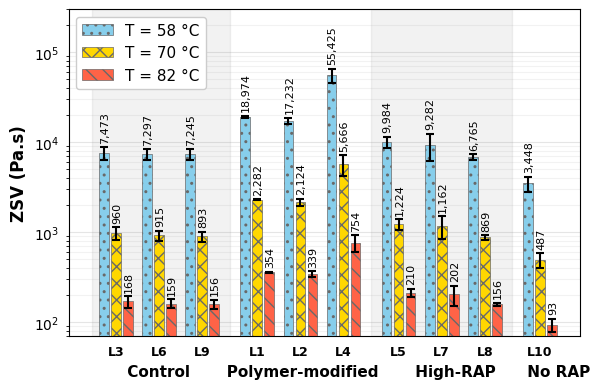

In [26]:
# Second figure, which is used in the manuscript, is a bar plot of the ZSV values at 58, 70 and 82°C, as these 
#   temperatures are closer to the higher service temperatures at which the rutting could occur.
fig, ax = plt.subplots(1, 1, figsize=(6, 4.0))
Index = np.array([3, 6, 9, 1, 2, 4, 5, 7, 8, 10])
# Save the chart so we can loop through the bars below.
ax.axvspan(xmin=-1,   xmax=10.5, color='gray', alpha=0.1)
ax.axvspan(xmin=22.3, xmax=34.1, color='gray', alpha=0.1)
XPositions = np.array([3.6 * i + j + 0.0 for i in range(0, 3) for j in range(3)] + \
                      [3.6 * i + j + 1.0 for i in range(3, 6) for j in range(3)] + \
                      [3.6 * i + j + 2.0 for i in range(6, 9) for j in range(3)] + \
                      [3.6 * i + j + 3.0 for i in range(9, 10) for j in range(3)])
bar1 = ax.bar(x=XPositions[0::3], 
              height=[np.array([FS[f'L{ln}']['ZSV'][f'Rep{rep}']['ZSV_mPa.s'][-3] for rep in range(1, 4)]).mean() for ln in Index], 
              yerr=[np.array([FS[f'L{ln}']['ZSV'][f'Rep{rep}']['ZSV_mPa.s'][-3] for rep in range(1, 4)]).std() for ln in Index], 
              width=0.8, edgecolor='dimgray', lw=0.5, color='skyblue', hatch='..', label='T = 58 °C',
              error_kw={'capsize': 3, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
bar2 = ax.bar(x=XPositions[1::3], 
              height=[np.array([FS[f'L{ln}']['ZSV'][f'Rep{rep}']['ZSV_mPa.s'][-2] for rep in range(1, 4)]).mean() for ln in Index], 
              yerr=[np.array([FS[f'L{ln}']['ZSV'][f'Rep{rep}']['ZSV_mPa.s'][-2] for rep in range(1, 4)]).std() for ln in Index], 
              width=0.8, edgecolor='dimgray', lw=0.5, color='gold', hatch='xx', label='T = 70 °C',
              error_kw={'capsize': 3, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
bar3 = ax.bar(x=XPositions[2::3], 
              height=[np.array([FS[f'L{ln}']['ZSV'][f'Rep{rep}']['ZSV_mPa.s'][-1] for rep in range(1, 4)]).mean() for ln in Index], 
              yerr=[np.array([FS[f'L{ln}']['ZSV'][f'Rep{rep}']['ZSV_mPa.s'][-1] for rep in range(1, 4)]).std() for ln in Index], 
              width=0.8, edgecolor='dimgray', lw=0.5, color='tomato', hatch='\\\\', label='T = 82 °C',
              error_kw={'capsize': 3, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
for i, idx in enumerate(Index):
    ax.text(XPositions[3*i+0] + 0.08, 
            10 ** (np.log10(np.array([FS[f'L{idx}']['ZSV'][f'Rep{rep}']['ZSV_mPa.s'][-3] for rep in range(1, 4)]).mean() + 
                            np.array([FS[f'L{idx}']['ZSV'][f'Rep{rep}']['ZSV_mPa.s'][-3] for rep in range(1, 4)]).std()) + 0.05), 
            f"{np.array([FS[f'L{idx}']['ZSV'][f'Rep{rep}']['ZSV_mPa.s'][-3] for rep in range(1, 4)]).mean():,.0f}", 
            fontsize=8, va='bottom', ha='center', rotation=90)
    ax.text(XPositions[3*i+1] + 0.08,
            10 ** (np.log10(np.array([FS[f'L{idx}']['ZSV'][f'Rep{rep}']['ZSV_mPa.s'][-2] for rep in range(1, 4)]).mean() + 
                            np.array([FS[f'L{idx}']['ZSV'][f'Rep{rep}']['ZSV_mPa.s'][-2] for rep in range(1, 4)]).std()) + 0.05), 
            f"{np.array([FS[f'L{idx}']['ZSV'][f'Rep{rep}']['ZSV_mPa.s'][-2] for rep in range(1, 4)]).mean():,.0f}", 
            fontsize=8, va='bottom', ha='center', rotation=90)
    ax.text(XPositions[3*i+2] + 0.08, 
            10 ** (np.log10(np.array([FS[f'L{idx}']['ZSV'][f'Rep{rep}']['ZSV_mPa.s'][-1] for rep in range(1, 4)]).mean() + 
                            np.array([FS[f'L{idx}']['ZSV'][f'Rep{rep}']['ZSV_mPa.s'][-1] for rep in range(1, 4)]).std()) + 0.05), 
            f"{np.array([FS[f'L{idx}']['ZSV'][f'Rep{rep}']['ZSV_mPa.s'][-1] for rep in range(1, 4)]).mean():,.0f}", 
            fontsize=8, va='bottom', ha='center', rotation=90)
# Axis formatting.
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(which='major', color='gray', alpha=0.2)
ax.yaxis.grid(which='minor', color='gray', alpha=0.1)
ax.xaxis.grid(False)
ax.set_xticks(XPositions[1::3])
ax.set_xticklabels([f'L{i}' for i in Index], fontsize=9, fontweight='bold')
ax.set_ylabel('ZSV (Pa.s)', color='k', fontsize=12, fontweight='bold')
ax.set_xlabel('             Control       Polymer-modified       High-RAP      No RAP', 
              fontsize=11, fontweight='bold', color='k')
ax.legend(fontsize=11, ncol=1, fancybox=True, framealpha=1.0, loc='upper left')
ax.set_yscale('log')
ax.set_ylim([7e1, 3e5])
fig.tight_layout()
# fig.savefig(os.path.join(OutputDir, 'Presentation Figures', f'Binder_ZSV_Isothermal.png'), format='png', dpi=1000)
# fig.savefig(os.path.join(OutputDir, 'Presentation Figures', f'Binder_ZSV_Isothermal.svg'), format='svg')

_______

## Plot the Shenoy parameter. 

Plotting the Shenoy parameter only at 58°C and 70°C. 

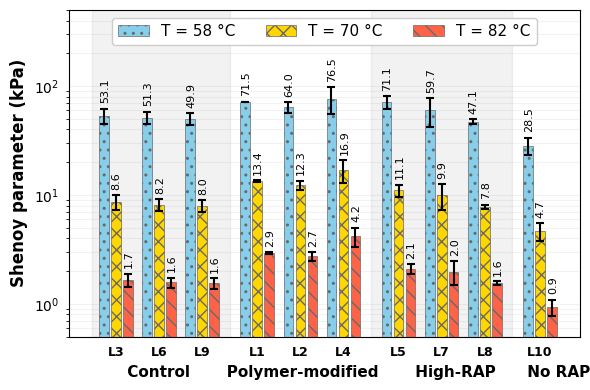

In [27]:
# Second figure, which is used in the manuscript, is a bar plot of the ZSV values at 58, 70 and 82°C, as these 
#   temperatures are closer to the higher service temperatures at which the rutting could occur.
fig, ax = plt.subplots(1, 1, figsize=(6, 4.0))
Index = np.array([3, 6, 9, 1, 2, 4, 5, 7, 8, 10])
# Save the chart so we can loop through the bars below.
ax.axvspan(xmin=-1,   xmax=10.5, color='gray', alpha=0.1)
ax.axvspan(xmin=22.3, xmax=34.1, color='gray', alpha=0.1)
XPositions = np.array([3.6 * i + j + 0.0 for i in range(0, 3) for j in range(3)] + \
                      [3.6 * i + j + 1.0 for i in range(3, 6) for j in range(3)] + \
                      [3.6 * i + j + 2.0 for i in range(6, 9) for j in range(3)] + \
                      [3.6 * i + j + 3.0 for i in range(9, 10) for j in range(3)])
bar1 = ax.bar(x=XPositions[0::3], 
              height=[np.array([FS[f'L{ln}']['Shenoy'][f'Rep{rep}']['ShenoyParam_kPa'][-3] for rep in range(1, 4)]).mean() for ln in Index], 
              yerr=[np.array([FS[f'L{ln}']['Shenoy'][f'Rep{rep}']['ShenoyParam_kPa'][-3] for rep in range(1, 4)]).std() for ln in Index], 
              width=0.8, edgecolor='dimgray', lw=0.5, color='skyblue', hatch='..', label='T = 58 °C',
              error_kw={'capsize': 3, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
bar2 = ax.bar(x=XPositions[1::3], 
              height=[np.array([FS[f'L{ln}']['Shenoy'][f'Rep{rep}']['ShenoyParam_kPa'][-2] for rep in range(1, 4)]).mean() for ln in Index], 
              yerr=[np.array([FS[f'L{ln}']['Shenoy'][f'Rep{rep}']['ShenoyParam_kPa'][-2] for rep in range(1, 4)]).std() for ln in Index], 
              width=0.8, edgecolor='dimgray', lw=0.5, color='gold', hatch='xx', label='T = 70 °C',
              error_kw={'capsize': 3, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
bar3 = ax.bar(x=XPositions[2::3], 
              height=[np.array([FS[f'L{ln}']['Shenoy'][f'Rep{rep}']['ShenoyParam_kPa'][-1] for rep in range(1, 4)]).mean() for ln in Index], 
              yerr=[np.array([FS[f'L{ln}']['Shenoy'][f'Rep{rep}']['ShenoyParam_kPa'][-1] for rep in range(1, 4)]).std() for ln in Index], 
              width=0.8, edgecolor='dimgray', lw=0.5, color='tomato', hatch='\\\\', label='T = 82 °C',
              error_kw={'capsize': 3, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
for i, idx in enumerate(Index):
    ax.text(XPositions[3*i+0] + 0.08, 
            10 ** (np.log10(np.array([FS[f'L{idx}']['Shenoy'][f'Rep{rep}']['ShenoyParam_kPa'][-3] for rep in range(1, 4)]).mean() + 
                            np.array([FS[f'L{idx}']['Shenoy'][f'Rep{rep}']['ShenoyParam_kPa'][-3] for rep in range(1, 4)]).std()) + 0.05), 
            f"{np.array([FS[f'L{idx}']['Shenoy'][f'Rep{rep}']['ShenoyParam_kPa'][-3] for rep in range(1, 4)]).mean():.1f}", 
            fontsize=8, va='bottom', ha='center', rotation=90)
    ax.text(XPositions[3*i+1] + 0.08,
            10 ** (np.log10(np.array([FS[f'L{idx}']['Shenoy'][f'Rep{rep}']['ShenoyParam_kPa'][-2] for rep in range(1, 4)]).mean() + 
                            np.array([FS[f'L{idx}']['Shenoy'][f'Rep{rep}']['ShenoyParam_kPa'][-2] for rep in range(1, 4)]).std()) + 0.05), 
            f"{np.array([FS[f'L{idx}']['Shenoy'][f'Rep{rep}']['ShenoyParam_kPa'][-2] for rep in range(1, 4)]).mean():.1f}", 
            fontsize=8, va='bottom', ha='center', rotation=90)
    ax.text(XPositions[3*i+2] + 0.08, 
            10 ** (np.log10(np.array([FS[f'L{idx}']['Shenoy'][f'Rep{rep}']['ShenoyParam_kPa'][-1] for rep in range(1, 4)]).mean() + 
                            np.array([FS[f'L{idx}']['Shenoy'][f'Rep{rep}']['ShenoyParam_kPa'][-1] for rep in range(1, 4)]).std()) + 0.05), 
            f"{np.array([FS[f'L{idx}']['Shenoy'][f'Rep{rep}']['ShenoyParam_kPa'][-1] for rep in range(1, 4)]).mean():.1f}", 
            fontsize=8, va='bottom', ha='center', rotation=90)
# Axis formatting.
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(which='both', color='gray', alpha=0.1)
ax.xaxis.grid(False)
ax.set_xticks(XPositions[1::3])
ax.set_xticklabels([f'L{i}' for i in Index], fontsize=9, fontweight='bold')
ax.set_ylabel('Shenoy parameter (kPa)', color='k', fontsize=12, fontweight='bold')
ax.set_xlabel('             Control       Polymer-modified       High-RAP      No RAP', 
              fontsize=11, fontweight='bold', color='k')
ax.legend(fontsize=11, ncol=3, fancybox=True, framealpha=1.0, loc='upper center')
ax.set_yscale('log')
ax.set_ylim([5e-1, 5e2])
fig.tight_layout()
# fig.savefig(os.path.join(OutputDir, 'Presentation Figures', f'Binder_Shenoy_Isothermal.png'), format='png', dpi=1000)
# fig.savefig(os.path.join(OutputDir, 'Presentation Figures', f'Binder_Shenoy_Isothermal.svg'), format='svg')

______

## Combined plot for the ZSV and Shenoy together. 

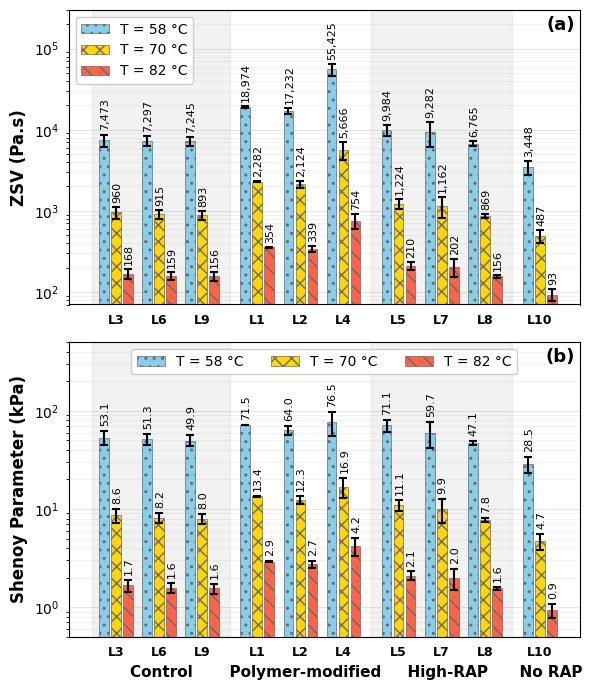

In [ ]:
# Second figure, which is used in the manuscript, is a bar plot of the ZSV values at 58, 70 and 82°C, as these 
#   temperatures are closer to the higher service temperatures at which the rutting could occur.
fig, axes = plt.subplots(2, 1, figsize=(6, 7.0))
Index = np.array([3, 6, 9, 1, 2, 4, 5, 7, 8, 10])
# Save the chart so we can loop through the bars below.
for ax in [axes[0], axes[1]]:
    ax.axvspan(xmin=-1,   xmax=10.5, color='gray', alpha=0.1)
    ax.axvspan(xmin=22.3, xmax=34.1, color='gray', alpha=0.1)
XPositions = np.array([3.6 * i + j + 0.0 for i in range(0, 3) for j in range(3)] + \
                      [3.6 * i + j + 1.0 for i in range(3, 6) for j in range(3)] + \
                      [3.6 * i + j + 2.0 for i in range(6, 9) for j in range(3)] + \
                      [3.6 * i + j + 3.0 for i in range(9, 10) for j in range(3)])
# ----------------------------------------------------------------------------------------------------------------------
# First plot the ZSV. 
ax = axes[0]
bar1 = ax.bar(x=XPositions[0::3], 
              height=[np.array([FS[f'L{ln}']['ZSV'][f'Rep{rep}']['ZSV_mPa.s'][-3] for rep in range(1, 4)]).mean() for ln in Index], 
              yerr=[np.array([FS[f'L{ln}']['ZSV'][f'Rep{rep}']['ZSV_mPa.s'][-3] for rep in range(1, 4)]).std() for ln in Index], 
              width=0.8, edgecolor='dimgray', lw=0.5, color='skyblue', hatch='..', label='T = 58 °C',
              error_kw={'capsize': 3, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
bar2 = ax.bar(x=XPositions[1::3], 
              height=[np.array([FS[f'L{ln}']['ZSV'][f'Rep{rep}']['ZSV_mPa.s'][-2] for rep in range(1, 4)]).mean() for ln in Index], 
              yerr=[np.array([FS[f'L{ln}']['ZSV'][f'Rep{rep}']['ZSV_mPa.s'][-2] for rep in range(1, 4)]).std() for ln in Index], 
              width=0.8, edgecolor='dimgray', lw=0.5, color='gold', hatch='xx', label='T = 70 °C',
              error_kw={'capsize': 3, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
bar3 = ax.bar(x=XPositions[2::3], 
              height=[np.array([FS[f'L{ln}']['ZSV'][f'Rep{rep}']['ZSV_mPa.s'][-1] for rep in range(1, 4)]).mean() for ln in Index], 
              yerr=[np.array([FS[f'L{ln}']['ZSV'][f'Rep{rep}']['ZSV_mPa.s'][-1] for rep in range(1, 4)]).std() for ln in Index], 
              width=0.8, edgecolor='dimgray', lw=0.5, color='tomato', hatch='\\\\', label='T = 82 °C',
              error_kw={'capsize': 3, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
for i, idx in enumerate(Index):
    ax.text(XPositions[3*i+0] + 0.08, 
            10 ** (np.log10(np.array([FS[f'L{idx}']['ZSV'][f'Rep{rep}']['ZSV_mPa.s'][-3] for rep in range(1, 4)]).mean() + 
                            np.array([FS[f'L{idx}']['ZSV'][f'Rep{rep}']['ZSV_mPa.s'][-3] for rep in range(1, 4)]).std()) + 0.05), 
            f"{np.array([FS[f'L{idx}']['ZSV'][f'Rep{rep}']['ZSV_mPa.s'][-3] for rep in range(1, 4)]).mean():,.0f}", 
            fontsize=8, va='bottom', ha='center', rotation=90)
    ax.text(XPositions[3*i+1] + 0.08,
            10 ** (np.log10(np.array([FS[f'L{idx}']['ZSV'][f'Rep{rep}']['ZSV_mPa.s'][-2] for rep in range(1, 4)]).mean() + 
                            np.array([FS[f'L{idx}']['ZSV'][f'Rep{rep}']['ZSV_mPa.s'][-2] for rep in range(1, 4)]).std()) + 0.05), 
            f"{np.array([FS[f'L{idx}']['ZSV'][f'Rep{rep}']['ZSV_mPa.s'][-2] for rep in range(1, 4)]).mean():,.0f}", 
            fontsize=8, va='bottom', ha='center', rotation=90)
    ax.text(XPositions[3*i+2] + 0.08, 
            10 ** (np.log10(np.array([FS[f'L{idx}']['ZSV'][f'Rep{rep}']['ZSV_mPa.s'][-1] for rep in range(1, 4)]).mean() + 
                            np.array([FS[f'L{idx}']['ZSV'][f'Rep{rep}']['ZSV_mPa.s'][-1] for rep in range(1, 4)]).std()) + 0.05), 
            f"{np.array([FS[f'L{idx}']['ZSV'][f'Rep{rep}']['ZSV_mPa.s'][-1] for rep in range(1, 4)]).mean():,.0f}", 
            fontsize=8, va='bottom', ha='center', rotation=90)
# ----------------------------------------------------------------------------------------------------------------------
# Second plot: Shenpy parameter. 
ax = axes[1]
bar1 = ax.bar(x=XPositions[0::3], 
              height=[np.array([FS[f'L{ln}']['Shenoy'][f'Rep{rep}']['ShenoyParam_kPa'][-3] for rep in range(1, 4)]).mean() for ln in Index], 
              yerr=[np.array([FS[f'L{ln}']['Shenoy'][f'Rep{rep}']['ShenoyParam_kPa'][-3] for rep in range(1, 4)]).std() for ln in Index], 
              width=0.8, edgecolor='dimgray', lw=0.5, color='skyblue', hatch='..', label='T = 58 °C',
              error_kw={'capsize': 3, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
bar2 = ax.bar(x=XPositions[1::3], 
              height=[np.array([FS[f'L{ln}']['Shenoy'][f'Rep{rep}']['ShenoyParam_kPa'][-2] for rep in range(1, 4)]).mean() for ln in Index], 
              yerr=[np.array([FS[f'L{ln}']['Shenoy'][f'Rep{rep}']['ShenoyParam_kPa'][-2] for rep in range(1, 4)]).std() for ln in Index], 
              width=0.8, edgecolor='dimgray', lw=0.5, color='gold', hatch='xx', label='T = 70 °C',
              error_kw={'capsize': 3, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
bar3 = ax.bar(x=XPositions[2::3], 
              height=[np.array([FS[f'L{ln}']['Shenoy'][f'Rep{rep}']['ShenoyParam_kPa'][-1] for rep in range(1, 4)]).mean() for ln in Index], 
              yerr=[np.array([FS[f'L{ln}']['Shenoy'][f'Rep{rep}']['ShenoyParam_kPa'][-1] for rep in range(1, 4)]).std() for ln in Index], 
              width=0.8, edgecolor='dimgray', lw=0.5, color='tomato', hatch='\\\\', label='T = 82 °C',
              error_kw={'capsize': 3, 'capthick': 1.5, 'elinewidth': 1.5, 'ecolor': 'black'})
for i, idx in enumerate(Index):
    ax.text(XPositions[3*i+0] + 0.08, 
            10 ** (np.log10(np.array([FS[f'L{idx}']['Shenoy'][f'Rep{rep}']['ShenoyParam_kPa'][-3] for rep in range(1, 4)]).mean() + 
                            np.array([FS[f'L{idx}']['Shenoy'][f'Rep{rep}']['ShenoyParam_kPa'][-3] for rep in range(1, 4)]).std()) + 0.05), 
            f"{np.array([FS[f'L{idx}']['Shenoy'][f'Rep{rep}']['ShenoyParam_kPa'][-3] for rep in range(1, 4)]).mean():.1f}", 
            fontsize=8, va='bottom', ha='center', rotation=90)
    ax.text(XPositions[3*i+1] + 0.08,
            10 ** (np.log10(np.array([FS[f'L{idx}']['Shenoy'][f'Rep{rep}']['ShenoyParam_kPa'][-2] for rep in range(1, 4)]).mean() + 
                            np.array([FS[f'L{idx}']['Shenoy'][f'Rep{rep}']['ShenoyParam_kPa'][-2] for rep in range(1, 4)]).std()) + 0.05), 
            f"{np.array([FS[f'L{idx}']['Shenoy'][f'Rep{rep}']['ShenoyParam_kPa'][-2] for rep in range(1, 4)]).mean():.1f}", 
            fontsize=8, va='bottom', ha='center', rotation=90)
    ax.text(XPositions[3*i+2] + 0.08, 
            10 ** (np.log10(np.array([FS[f'L{idx}']['Shenoy'][f'Rep{rep}']['ShenoyParam_kPa'][-1] for rep in range(1, 4)]).mean() + 
                            np.array([FS[f'L{idx}']['Shenoy'][f'Rep{rep}']['ShenoyParam_kPa'][-1] for rep in range(1, 4)]).std()) + 0.05), 
            f"{np.array([FS[f'L{idx}']['Shenoy'][f'Rep{rep}']['ShenoyParam_kPa'][-1] for rep in range(1, 4)]).mean():.1f}", 
            fontsize=8, va='bottom', ha='center', rotation=90)
# ----------------------------------------------------------------------------------------------------------------------
# Axis formatting.
for ax in [axes[0], axes[1]]:
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    ax.yaxis.grid(which='major', color='gray', alpha=0.2)
    ax.yaxis.grid(which='minor', color='gray', alpha=0.1)
    ax.xaxis.grid(False)
    ax.set_xticks(XPositions[1::3])
    ax.set_xticklabels([f'L{i}' for i in Index], fontsize=9, fontweight='bold')
    ax.set_yscale('log')
axes[0].legend(fontsize=10, ncol=1, fancybox=True, framealpha=1.0, loc='upper left')
axes[1].legend(fontsize=10, ncol=3, fancybox=True, framealpha=1.0, loc='upper center')
axes[0].set_ylabel('ZSV (Pa.s)', color='k', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Shenoy Parameter (kPa)', color='k', fontsize=12, fontweight='bold')
axes[1].set_xlabel('            Control       Polymer-modified     High-RAP      No RAP', 
            fontsize=11, fontweight='bold', color='k')
axes[0].set_ylim([7e1, 3e5])
axes[1].set_ylim([5e-1, 5e2])
axes[0].text(0.99, 0.98, '(a)', transform=axes[0].transAxes, ha='right', va='top', fontsize=13, fontweight='bold')
axes[1].text(0.99, 0.98, '(b)', transform=axes[1].transAxes, ha='right', va='top', fontsize=13, fontweight='bold')
fig.tight_layout()
# fig.savefig(os.path.join(OutputDir, f'Binder_ZSV_Shenoy_Isothermal.png'), format='png', dpi=1000)
# fig.savefig(os.path.join(OutputDir, f'Binder_ZSV_Shenoy_Isothermal.pdf'), format='pdf')
# fig.savefig(os.path.join(OutputDir, f'Binder_ZSV_Shenoy_Isothermal.svg'), format='svg')

Perform the statistical analysis. 

In [29]:
data = {'value': [], 'group': [], 'temp': [], 'type': []}
for ln in range(1, 11):
    for j, temp in enumerate([82, 70, 58]):
        for rep in [1, 2, 3]:
            data['value'].append(np.log10(FS[f'L{ln}']['ZSV'][f'Rep{rep}']['ZSV_mPa.s'][-(j+1)]))
            data['group'].append(f'L{ln:02d}')
            data['temp'].append(temp)
            data['type'].append('ZSV')
            # For the Shenoy.
            data['value'].append(np.log10(FS[f'L{ln}']['Shenoy'][f'Rep{rep}']['ShenoyParam_kPa'][-(j+1)]))
            data['group'].append(f'L{ln:02d}')
            data['temp'].append(temp)
            data['type'].append('Shenoy')
data = pd.DataFrame(data)
Pairwise_ZSV58, Grouping_ZSV58 = Tukey_Grouping(data[(data['temp'] == 58) & (data['type'] == 'ZSV')])
Pairwise_ZSV70, Grouping_ZSV70 = Tukey_Grouping(data[(data['temp'] == 70) & (data['type'] == 'ZSV')])
Pairwise_ZSV82, Grouping_ZSV82 = Tukey_Grouping(data[(data['temp'] == 82) & (data['type'] == 'ZSV')])
Pairwise_Shenoy58, Grouping_Shenoy58 = Tukey_Grouping(data[(data['temp'] == 58) & (data['type'] == 'Shenoy')])
Pairwise_Shenoy70, Grouping_Shenoy70 = Tukey_Grouping(data[(data['temp'] == 70) & (data['type'] == 'Shenoy')])
Pairwise_Shenoy82, Grouping_Shenoy82 = Tukey_Grouping(data[(data['temp'] == 82) & (data['type'] == 'Shenoy')])

In [30]:
# Generate the table for the ZSV. 
Grouping_ZSV58.rename(columns={'Grouping': 'ZSV58'}, inplace=True)
Grouping_ZSV70.rename(columns={'Grouping': 'ZSV70'}, inplace=True)
Grouping_ZSV82.rename(columns={'Grouping': 'ZSV82'}, inplace=True)
Grouping_ZSV70.drop('Group', axis=1, inplace=True)
Grouping_ZSV82.drop('Group', axis=1, inplace=True)
pd.concat((Grouping_ZSV58, Grouping_ZSV70, Grouping_ZSV82), axis=1)

,Group,ZSV58,ZSV70,ZSV82
0,L01,A,A,A
1,L02,A,"A,B","A,B"
2,L03,B,C,C
3,L04,C,D,D
4,L05,"A,B","A,C","A,C"
5,L06,B,"C,E","C,E"
6,L07,B,"B,C","B,C"
7,L08,B,"C,F","C,F"
8,L09,B,"C,G","C,G"
9,L10,D,"E,F,G","E,F,G"


In [31]:
# Generate the table for the ZSV. 
Grouping_Shenoy58.rename(columns={'Grouping': 'Shenoy58'}, inplace=True)
Grouping_Shenoy70.rename(columns={'Grouping': 'Shenoy70'}, inplace=True)
Grouping_Shenoy82.rename(columns={'Grouping': 'Shenoy82'}, inplace=True)
Grouping_Shenoy70.drop('Group', axis=1, inplace=True)
Grouping_Shenoy82.drop('Group', axis=1, inplace=True)
pd.concat((Grouping_Shenoy58, Grouping_Shenoy70, Grouping_Shenoy82), axis=1)

,Group,Shenoy58,Shenoy70,Shenoy82
0,L01,A,A,A
1,L02,A,A,"A,B"
2,L03,"A,B",A,"B,C"
3,L04,A,A,A
4,L05,A,A,"A,C"
5,L06,"A,C","A,B","C,D"
6,L07,A,A,"A,C"
7,L08,"A,D","A,C","C,E"
8,L09,"A,E","A,D","C,F"
9,L10,"B,C,D,E","B,C,D","D,E,F"


_______

## Plot the master curves. 

Plotting the master curves of Shenoy parameter and |G*|/sinδ in the reduced frequencies corresponds to the high-temperatures. 

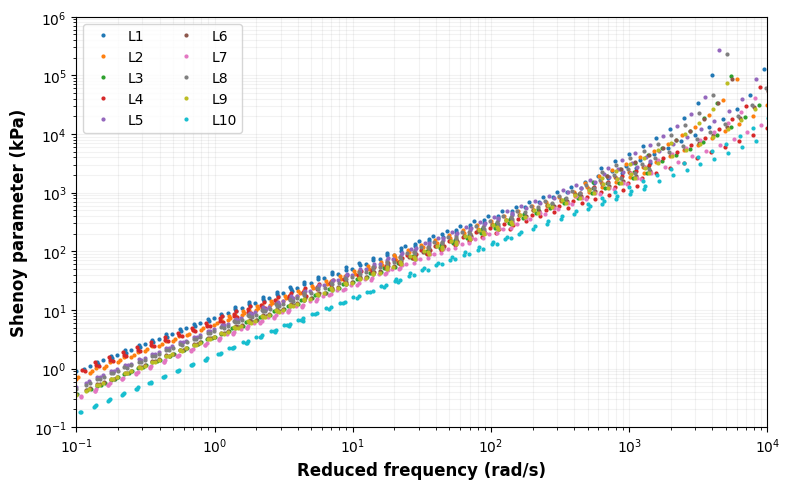

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
for ln in FS.keys():
    plt.loglog(FS[ln]['Data']['Rep1']['Reduced Frequency (rad/s)'], 
               FS[ln]['Data']['Rep1']['Shenoy Parameter (kPa)'], ls='', marker='o', ms=2, label=ln)
ax.legend(ncol=2)
ax.set_xlabel('Reduced frequency (rad/s)', fontsize=12, fontweight='bold', color='k')
ax.set_ylabel('Shenoy parameter (kPa)', fontsize=12, fontweight='bold', color='k')
ax.grid(which='both', color='gray', alpha=0.1)
ax.set_xlim([1e-1, 1e4])
ax.set_ylim([1e-1, 1e6])
fig.tight_layout()

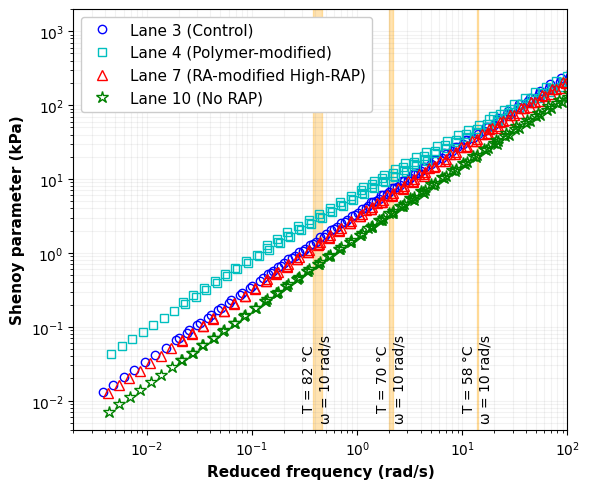

In [34]:
Color = ['b', 'c', 'r', 'g']
MS = [6, 6, 7, 9]
Label = ['Lane 3 (Control)', 'Lane 4 (Polymer-modified)', 'Lane 7 (RA-modified High-RAP)', 'Lane 10 (No RAP)']
Lanes = ['L3', 'L4', 'L7', 'L10']
MinMax = {'Min58': 1e10, 'Max58': 1e-10, 'Min70':1e10, 'Max70': 1e-10, 'Min82': 1e10, 'Max82': 1e-10}
for ln in Lanes: 
    for temp in [58, 70, 82]:
        for rep in [1]:
            w = FS[ln]['Data'][f'Rep{rep}'][(FS[ln]['Data'][f'Rep{rep}']['Angular Frequency (rad/s)'] == 10) & \
                                            (FS[ln]['Data'][f'Rep{rep}']['Temperature (°C)'] == temp)]['Reduced Frequency (rad/s)']
            if MinMax[f'Min{temp}'] > w.min(): MinMax[f'Min{temp}'] = w.min()
            if MinMax[f'Max{temp}'] < w.max(): MinMax[f'Max{temp}'] = w.max()
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
for temp in [58, 70, 82]:
    ax.axvspan(xmin=MinMax[f'Min{temp}'], xmax=MinMax[f'Max{temp}'], color='orange', alpha=0.3)
    ax.text(10 ** ((np.log10(MinMax[f'Min{temp}']) + np.log10(MinMax[f'Max{temp}'])) / 2), 5e-3, f'T = {temp} °C\nω = 10 rad/s', 
            rotation=90, va='bottom', ha='center')
for i, ln in enumerate(Lanes):
    plt.loglog(FS[ln]['Data'][f'Rep{rep}']['Reduced Frequency (rad/s)'], FS[ln]['Data'][f'Rep{rep}']['Shenoy Parameter (kPa)'], 
               ls='', marker=Marker[i], ms=MS[i], label=Label[i], alpha=1.0, color=Color[i], 
               markerfacecolor='none', markeredgewidth=1.0)
ax.legend(ncol=1, fontsize=11, framealpha=1.0)
ax.set_xlabel('Reduced frequency (rad/s)', fontsize=11, fontweight='bold', color='k')
ax.set_ylabel('Shenoy parameter (kPa)', fontsize=11, fontweight='bold', color='k')
ax.grid(which='both', color='gray', alpha=0.1)
ax.set_xlim([2e-3, 1e2])
ax.set_ylim([4e-3, 2e3])
fig.tight_layout()
# fig.savefig(os.path.join(OutputDir, f'Binder_Shenoy_MasterCurve.png'), bbox_inches='tight', format='png', dpi=1000)
# fig.savefig(os.path.join(OutputDir, f'Binder_Shenoy_MasterCurve.svg'), bbox_inches='tight', format='svg')

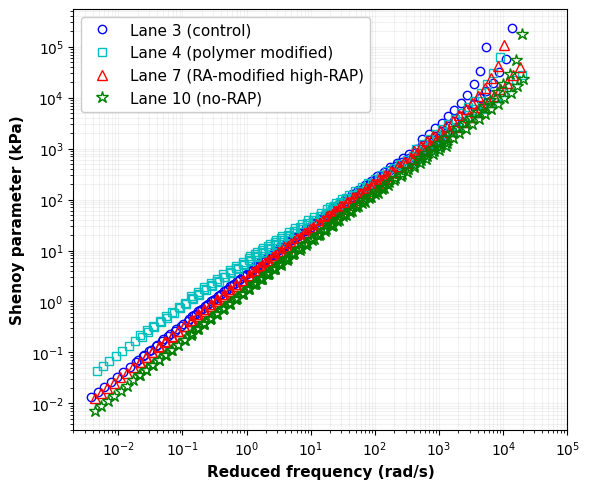

In [31]:
Color = ['b', 'c', 'r', 'g']
MS = [6, 6, 7, 9]
Label = ['Lane 3 (control)', 'Lane 4 (polymer modified)', 'Lane 7 (RA-modified high-RAP)', 'Lane 10 (no-RAP)']
Lanes = ['L3', 'L4', 'L7', 'L10']
MinMax = {'Min58': 1e10, 'Max58': 1e-10, 'Min70':1e10, 'Max70': 1e-10, 'Min82': 1e10, 'Max82': 1e-10}
for ln in Lanes: 
    for temp in [58, 70, 82]:
        for rep in [1]:
            w = FS[ln]['Data'][f'Rep{rep}'][(FS[ln]['Data'][f'Rep{rep}']['Angular Frequency (rad/s)'] == 10) & \
                                            (FS[ln]['Data'][f'Rep{rep}']['Temperature (°C)'] == temp)]['Reduced Frequency (rad/s)']
            if MinMax[f'Min{temp}'] > w.min(): MinMax[f'Min{temp}'] = w.min()
            if MinMax[f'Max{temp}'] < w.max(): MinMax[f'Max{temp}'] = w.max()
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
for i, ln in enumerate(Lanes):
    plt.loglog(FS[ln]['Data'][f'Rep{rep}']['Reduced Frequency (rad/s)'], FS[ln]['Data'][f'Rep{rep}']['Shenoy Parameter (kPa)'], 
               ls='', marker=Marker[i], ms=MS[i], label=Label[i], alpha=1.0, color=Color[i], 
               markerfacecolor='none', markeredgewidth=1.0)
ax.legend(ncol=1, fontsize=11, framealpha=1.0)
ax.set_xlabel('Reduced frequency (rad/s)', fontsize=11, fontweight='bold', color='k')
ax.set_ylabel('Shenoy parameter (kPa)', fontsize=11, fontweight='bold', color='k')
ax.grid(which='both', color='gray', alpha=0.1)
ax.set_xlim([2e-3, 1e5])
fig.tight_layout()
# fig.savefig(os.path.join(OutputDir, 'Presentation Figures', f'Binder_Shenoy_MasterCurve_Full.png'), bbox_inches='tight', format='png', dpi=1000)
# fig.savefig(os.path.join(OutputDir, 'Presentation Figures', f'Binder_Shenoy_MasterCurve_Full.svg'), bbox_inches='tight', format='svg')

_____

## Plot fitting Cross model to |η*|

Plot the |η*| isotherms of recovered binder from Lane 3 at 82°C and the fitted cross model. 

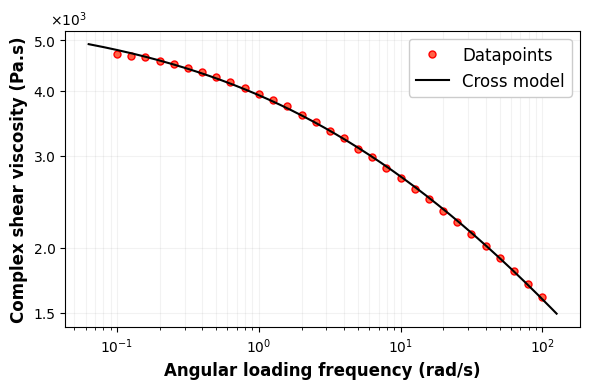

In [19]:
# Extract the data. 
Freq = FS['L3']['Data']['Rep1'][FS['L3']['Data']['Rep1']['Temperature (°C)'] == 58]['Angular Frequency (rad/s)'].to_numpy()
Visc = FS['L3']['Data']['Rep1'][FS['L3']['Data']['Rep1']['Temperature (°C)'] == 58]['Complex Viscosity (mPa.s)'].to_numpy()
ZSV, K, m = FS['L3']['ZSV']['Rep1']['CrossModelCoeffs'][-3]
w = np.logspace(-1.2, 2.1, num=1000)
# Plotting the data. 
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.loglog(Freq, Visc, ls='', marker='o', ms=5, color='k', markeredgecolor='r', markerfacecolor='tomato', label='Datapoints')
ax.loglog(w, 10 ** CrossModel(w, np.log10(ZSV), K, m), ls='-', color='k', lw=1.5, label='Cross model')
ax.set_xlabel('Angular loading frequency (rad/s)', fontsize=12, fontweight='bold', color='k')
ax.set_ylabel('Complex shear viscosity (Pa.s)', fontsize=12, fontweight='bold', color='k')
ax.grid(which='both', color='gray', alpha=0.1)
ax.legend(fontsize=12, fancybox=True, framealpha=1)
ax.set_yticks([1.5e3, 2e3, 3e3, 4e3, 5e3])
ax.set_yticklabels(['1.5', '2.0', '3.0', '4.0', '5.0'])
ax.text(-0.03, 1.01, r'$\times 10^3$', transform=ax.transAxes, ha='left', va='bottom', fontsize=10)
fig.tight_layout()
# fig.savefig(os.path.join(OutputDir, f'Binder_ZSV_CrossModel_Fit.png'), bbox_inches='tight', format='png', dpi=1000)
# fig.savefig(os.path.join(OutputDir, f'Binder_ZSV_CrossModel_Fit.pdf'), bbox_inches='tight', format='pdf')
# fig.savefig(os.path.join(OutputDir, f'Binder_ZSV_CrossModel_Fit.svg'), bbox_inches='tight', format='svg')

In [20]:
# Save the Frequency Sweep results in a Pickle file, to study the correlations. 
pickle.dump(FS, open('./Data/ProcessedData_FS.pkl', 'wb'))